# On the Microstructural Hedging Error

This notebook contains the implementation of the paper titled 'On the Microstructural Hedging Error'. The implementation is divided into the following steps:

1. **Model Construction**: Construct the model with an uncertainty zone and conduct a simulation study. The efficient price follows a Black-Scholes dynamics.

2. **Benchmark Frictionless Hedging Strategy**: Implement and evaluate a benchmark frictionless hedging strategy under the Black-Scholes dynamics.

3. **Hedging Strategy with Uncertainty Zone**: Develop hedging strategies that takes into account the uncertainty zone. The strategies will be evaluated in three scenarios: rebalancing for every change (with&without microstructural noise), and rebalancing at fixed optimal levels (with microstructural noise).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import seaborn as sns
import plotly.graph_objects as go

## Create Uncertainty Zone model

Let the sequence $(\tau_i)_{i\geq0}$ be the exit times from the uncertainty zones, which will lead to a change in the transaction price. Let $\tau_0 = 0$, and assume without loss of generality that $\tau_1$ is the exit time of $(X_t)_{t\geq0}$ from the set $(d_{k_0-1},u_{k_0})$, where $k_0 = \frac{X^{(\alpha)}_0}{\alpha}$, with $X^{(\alpha)}_0$ the value of $X_0$ rounded to the nearest multiple of $\alpha$. As explained later, the distribution of this variable will depend on the value of some market quantities at time $\tau_i$. Then define $\tau_{i+1}$ recursively as the exit time of $(X_t)_{t>\tau_i}$ from the set $(d_{k_i-1},u_{k_i}+L_{i-1})$, where $k_i = \frac{X^{(\alpha)}_{\tau_i}}{\alpha}$, that is,

$$
\tau_{i+1} = \inf \{ t > \tau_i, X_t = {X^{(\alpha)}_{\tau_i}} - \alpha\left( L_i - \frac{1}{2} + \eta \right) \text{ or } X_t = {X^{(\alpha)}_{\tau_i}}+ \alpha\left( L_i - \frac{1}{2} + \eta \right) \}.
$$

In particular, if $X_{\tau_i} = d_j$ for some $j \in \mathbb{N}$, $\tau_{i+1}$ is the exit time of $(X_t)_{t>\tau_i}$ from the set $(d_{j-L_i}, u_{j+L_i-1})$, and if $X_{\tau_i} = u_j$ for some $j \in \mathbb{N}$, $\tau_{i+1}$ is the exit time of $(X_t)_{t>\tau_i}$ from the set $(d_{j-L_i+1}, u_{j+L_i})$.

Let $P_0$ be the opening price. We define the last traded price $(P_t)_{t\geq0}$ as the càdlàg piecewise constant process built from the $(\tau_i, P_{\tau_i})_{i\geq0}$, where $P_{\tau_i} = X^{(\alpha)}_{\tau_i}$. It is, of course, quite unrealistic to assume that the transaction prices change exactly at the exit times $\tau_i$. However, it enables us to simplify some computations. Moreover, under additional assumptions, the results given in section 4 still hold in the initial model of [23], where delays caused by the reaction times of market participants and/or by the trading process are allowed.

Note that $\alpha L_i$ is the absolute value of the price jump between the ith and the (i + 1)st transactions with price change and that

$$
P_{\tau_i} = X_{\tau_i} + \text{sign}(X_{\tau_i} - X_{\tau_{i-1}})(1/2 - \eta)\alpha = X_{\tau_i} + \text{sign}(P_{\tau_i} - P_{\tau_{i-1}})(1/2 - \eta)\alpha.
$$


In [87]:
# simulate black scholes path dXt = sigma * XtdWt
def simulate_BS(sigma, x0, T, n):
    """
    Simulate geometric brownian motion
    under the scheme of Euler-Maruyama
    n: number of time steps
    T: terminal time
    x0: initial value
    """
    dt = T/n
    t = np.linspace(0, T, n) # time grid
    x = np.zeros(n)
    x[0] = x0
    for i in range(1, n):
        dW = np.random.normal() * np.sqrt(dt) # brownian increment
        x[i] = x[i-1] * np.exp(-0.5 * sigma**2 * dt + sigma * dW)
    return t, x

# a function that take the underlying price and return the price of uncertainty zone
def uncertainty_zone_price(x, alpha, eta, L):
    """
    input:
    x: the underlying price
    alpha: the ticksize
    eta: the proportion of continuation
    L: the size of jump
    output:
    p: the price of uncertainty zone
    eta_hat: the estimated proportion of continuation
    tau: list of times where transaction happens
    """
    p = np.zeros(len(x)) # price of uncertainty zone
    p_discrete = [] # discrete price under uncertainty zone model
    N_a = 0 # number of alternation
    N_c = 0 # number of continuation
    tau = [] # collect the time where transaction happens
    # construct the uncertainty zone price
    p[0] = x[0]
    p_discrete.append(p[0])
    for i in range(1, len(p)):
        if x[i] - p[i-1] >= alpha*(L-.5+eta): # if efficient price is higher than the upper bound
            p[i] = p[i-1] + L*alpha
            p_discrete.append(p[i])
            tau.append(i)
        elif x[i] - p[i-1] <= - alpha*(L-.5+eta): # if efficient price is lower than the lower bound
            p[i] = p[i-1] - L*alpha
            p_discrete.append(p[i])
            tau.append(i)
        else:
            p[i] = p[i-1] # last traded price remain the same
    # calculate the number of alternation and continuation
    p_discrete = np.array(p_discrete)
    for i in range(2, len(p_discrete)):
        if np.sign(p_discrete[i] - p_discrete[i-1]) != np.sign(p_discrete[i-1] - p_discrete[i-2]):
            N_a += 1
        else:
            N_c += 1
    eta_hat = N_c/(2*N_a)
    return p, eta_hat, tau

estimate of eta = 0.8 is 0.9545454545454546


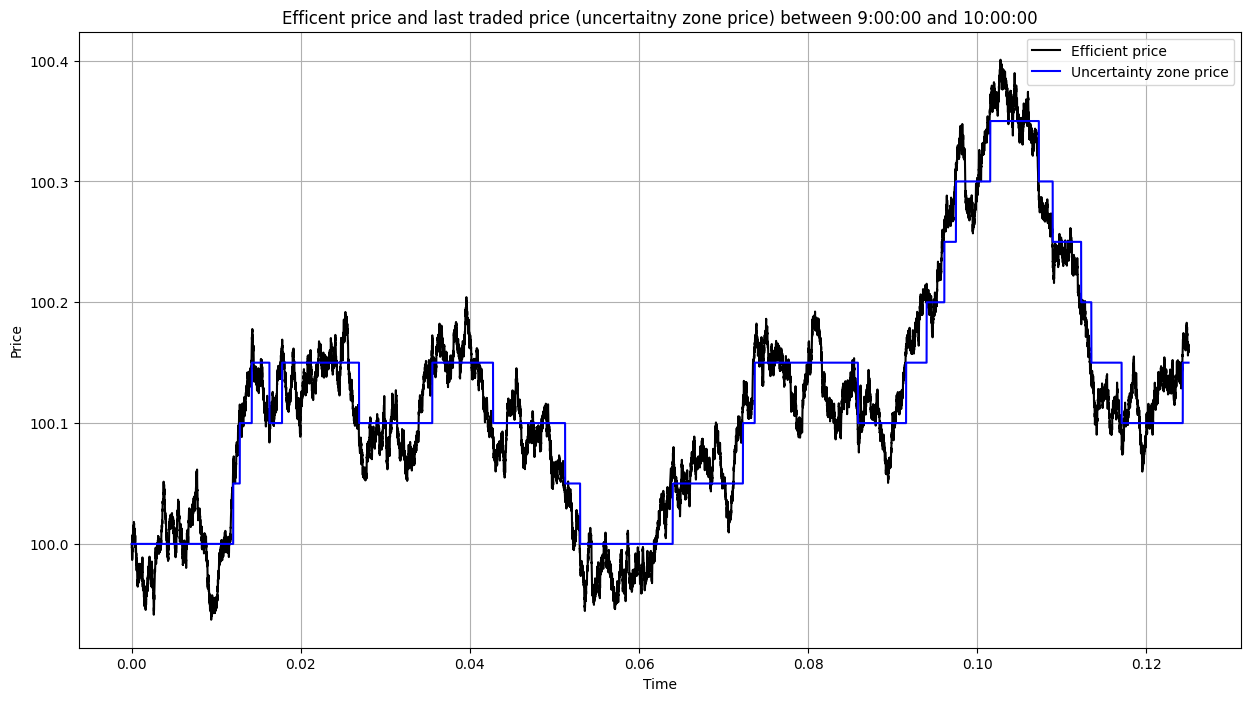

In [88]:
# initialize the parameters
x0 = 100
T = 1
alpha = 0.05 # ticksize
eta = 0.8 # price aversion, implicit spread is 2*alpha*eta, eta ->1 means very hard to trade
L = 1 # size of jump
sigma = 0.01
n = 10*3600*8 # 10 times per second
t, x = simulate_BS(sigma, x0, T, n)

p, eta_hat, tau = uncertainty_zone_price(x, alpha, eta, L)
print(f"estimate of eta = {eta} is {eta_hat}")
# plot the efficient price only between 9:00:00 and 10:00:00
time_end = 10* 3600
plt.figure(figsize = (15,8))
plt.plot(t[:time_end], x[:time_end],label = 'Efficient price', color = 'black')

# mark every time when there is price change
plt.plot(t[:time_end], p[:time_end], label = 'Uncertainty zone price', color = 'blue')

# change x axis to 9:00:00 to 17:00:00
#plt.xticks(np.arange(0, 1.1, 1/8), ['9:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00'])
plt.legend()
plt.ylabel('Price')
plt.xlabel('Time')
plt.grid()
plt.title("Efficent price and last traded price (uncertaitny zone price) between 9:00:00 and 10:00:00")
plt.show()

## Benchmark Frictionless Hedging Portfolio
- we might need to make some changes as the T in paper is one day and T in BS model is one year

We first create a benchmark frictionless hedging strategy:
$$
\Pi_t = C(0, X_0) + \int_{0}^{t} \frac{\partial C}{\partial x} (u, X_u) \, dX_u.\\
$$
and the discrete version is given as:
$$
\Pi_t = C(0, X_0) + \sum_{i=1}^{n} \frac{\partial C}{\partial x} (t_{i-1}, X_{t_{i-1}}) \cdot (X_{t_i} - X_{t_{i-1}})
$$
where we hedge at every timestep.

In [133]:
# create a frictionless hedging portfolio for European call option max(S-K, 0)
# we assume the option is at the money
K = 100
np.random.seed(1)
t, x = simulate_BS(sigma, x0, T, n)
# calculate the call option price
def BSCall(S0, K, sigma, T):
    '''
    #Inputs:
    S0: initial stock price
    K: strike
    sigma: daily volatility since we are using daily time steps
    T: time to maturity, here we consider T=1 as 5pm end of the day
    #Output:
    Black-Scholes Call price
    '''
    sigT = sigma*np.sqrt(T)
    k = np.log(K/S0)
    dp = -k / sigT + 0.5*sigT
    dm = dp - sigT
    return S0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))

def delta(S, K, sigma, T):
    """
    Calculate the delta of a call option
    S: stock price
    K: strike
    T: time to maturity
    """
    d1 = (np.log(S / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Initialize the portfolio value array and the hedging position array
portfolio_value = np.zeros(n) # benchmark hedging portfolio value
hedging_position = np.zeros(n)
call_option_price = np.zeros(n)

# Assume after we sell a unit of call, we hedge the portfolio by buying delta units of the underlying
# benchmark hedging rebalnce for every time step
call_option_price[0] = BSCall(x[0], K, sigma, T - t[0])
portfolio_value[0] = call_option_price[0]
hedging_position[0] = delta(x[0], K, sigma, T - t[0])

for i in tqdm(range(1, n),colour='green'):
    dT = T - t[i] # Remaining time to maturity
    # Update the portfolio value for changes in the option price and underlying asset
    portfolio_value[i] = portfolio_value[i-1] + hedging_position[i-1] * (x[i] - x[i-1])
    # Re-hedge the portfolio by adjusting the position in the underlying
    hedging_position[i] = delta(x[i], K, sigma, dT)
    # compute the call option price
    call_option_price[i] = BSCall(x[i], K, sigma, dT)



100%|█████████▉| 287943/287999 [00:25<00:00, 11510.52it/s]/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/3510676153.py:30: RuntimeWarning:

divide by zero encountered in scalar divide

/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/3510676153.py:19: RuntimeWarning:

divide by zero encountered in scalar divide

100%|██████████| 287999/287999 [00:25<00:00, 11470.57it/s]


End of day hedging error:-0.00031504375593427447


/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/3510676153.py:30: RuntimeWarning:

divide by zero encountered in divide



Text(0.5, 1.0, 'Portfolio value and hedging position')

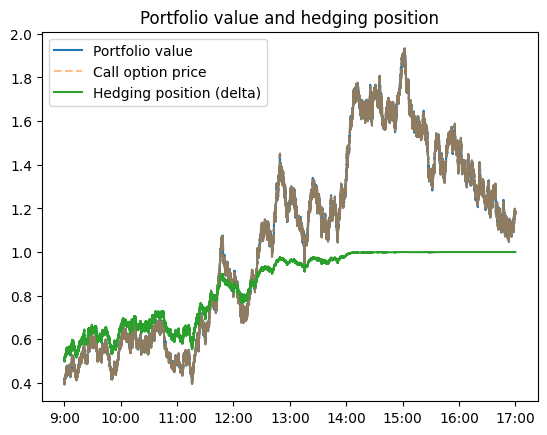

In [134]:
# calculate the error at the end of the day
print(f"End of day hedging error:{call_option_price[-1]-portfolio_value[-1]}")
plt.plot(t, portfolio_value, label = 'Portfolio value')
plt.plot(t, call_option_price, label = 'Call option price', linestyle = 'dashed',alpha = 0.5)
plt.plot(t, delta(x, K, sigma, T - t), label = 'Hedging position (delta)')
plt.legend()
plt.xticks(np.arange(0, 1.1, 1/8), ['9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00'])
plt.title("Portfolio value and hedging position")

## Hedging under the Uncertainty Zone Model

### Hedge for every price change, without microstructural noise


In this setting, we assume $P_{\tau_{i}} = X_{\tau_{i}}$. This imply we rebalance delta for every transaction time $\tau_{i}$ instead of every timestep $t_{i}$.
Let $\phi(t) = \sup\{\tau_i : \tau_i < t\}$, i.e., the moment before time $t$. In the absence of microstructure noise on the price, the hedging error is given by
$$
L^{(1)}_{\alpha,t} = \int_{0}^{T} \left[ \dot{C}_x (u, X_u) - \dot{C}_x (\phi(u), X_{\phi(u)}) \right] dX_u.\\

$$
with discrete version given as:
$$
L^{(1)}_{\alpha,t} = ({C}_x (T, X_T) - {C}_x (0, X_0)) - (\Pi_x(T,X_T) - \Pi_x(0,X_0)) \\
 = {C}_x (T, X_T) - \Pi_x(T,X_T)
$$

i.e. the error is simply the difference between the derivaitve and the hedging portfolio at maturity, which is the end of the day.
Note that we are only allowed to trade at stopping times $\{\tau_{i}\}_{i\geq 0}$.

In [135]:
# create a hedging portfolio where we only hedge at stopping time tau
p, eta_hat, tau = uncertainty_zone_price(x, alpha, eta, L)
# Initialize the portfolio value array and the hedging position array
portfolio_value_1 = np.zeros(len(tau)) # benchmark hedging portfolio value
hedging_position_1 = np.zeros(len(tau)) # hedging position dC/dS
call_option_price_1 = np.zeros(len(tau)) # call option price

# given the stopping time tau, we can calculate the hedging position and portfolio value
call_option_price_1[0] = BSCall(x[0], K, sigma, T - t[0])
portfolio_value_1[0] = call_option_price_1[0]
hedging_position_1[0] = delta(x[0], K, sigma, T - t[0])

for i in tqdm(range(1, len(tau)),colour='green'):
    dT = T - t[tau[i]] # Remaining time to maturity
    # Update the portfolio value for changes in the option price and underlying asset
    portfolio_value_1[i] = portfolio_value_1[i-1] + hedging_position_1[i-1] * (x[tau[i]] - x[tau[i-1]])
    # Re-hedge the portfolio by adjusting the position in the underlying
    hedging_position_1[i] = delta(x[tau[i]], K, sigma, dT)
    # compute the call option price
    call_option_price_1[i] = BSCall(x[tau[i]], K, sigma, dT)

100%|██████████| 2797/2797 [00:00<00:00, 11336.55it/s]


End of day hedging error: 0.019923447464601285


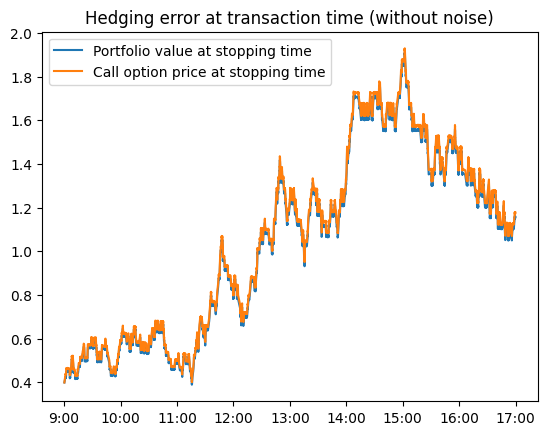

In [136]:
# calculate the hedging error
print(f"End of day hedging error: {call_option_price_1[-1]-portfolio_value_1[-1]}")
# plot the hedging error
plt.plot(t[tau], portfolio_value_1, label = 'Portfolio value at stopping time')
plt.plot(t[tau], call_option_price_1, label = 'Call option price at stopping time')
plt.legend()
plt.title("Hedging error at transaction time (without noise)")
plt.xticks(np.arange(0, 1.1, 1/8), ['9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00'])
plt.show()

In [137]:
# plotly fancy code
# calculate the hedging error
print(f"End of day hedging error: {call_option_price_1[-1]-portfolio_value_1[-1]}")

# create a plotly graph
fig = go.Figure()

# add traces
fig.add_trace(go.Scatter(x=t[tau], y=portfolio_value_1, mode='lines', name='Portfolio value at stopping time'))
fig.add_trace(go.Scatter(x=t[tau], y=call_option_price_1, mode='lines', name='Call option price at stopping time'))

# set the title
fig.update_layout(title='Hedging error at transaction time (without noise)')

# show the plot
fig.show()

End of day hedging error: 0.019923447464601285


### Hedge for every price change, with microstructural noise

In this setting, we no longer has $\forall \tau_i, P_{\tau_i} = X_{\tau_i}$, but instead, the relationship is given by:

$$
P_{\tau_i} = X_{\tau_i} + \text{sign}(X_{\tau_i} - X_{\tau_{i-1}})(1/2 - \eta)\alpha = X_{\tau_i} + \text{sign}(P_{\tau_i} - P_{\tau_{i-1}})(1/2 - \eta)\alpha.
$$
The hedging error is given as:
$$
L^{(2)}_{\alpha,t} = \int_{0}^{T}  \dot{C}_x (u, X_u) dX_u   - \int_{0}^{T}\dot{C}_x (\phi(u), X_{\phi(u)}) dP_u \\

$$
with discrete version given as (need revisit):

$$
L^{(2)}_{\alpha,t} = C_x (T, X_T)- \left( \sum_{i=1}^{n} \Delta C_x (t_{i-1}, X_{t_{i-1}}) \cdot (P_{t_i} - P_{t_{i-1}}) \right) \\

$$


In [138]:
p, eta_hat, tau = uncertainty_zone_price(x, alpha, eta, L)
# Initialize the portfolio value array and the hedging position array
portfolio_value_2 = np.zeros(len(tau)) # benchmark hedging portfolio value
hedging_position_2 = np.zeros(len(tau)) # hedging position dC/dS
call_option_price_2 = np.zeros(len(tau)) # call option price

# given the stopping time tau, we can calculate the hedging position and portfolio value
call_option_price_2[0] = BSCall(x[0], K, sigma, T - t[0])
portfolio_value_2[0] = call_option_price_2[0]
hedging_position_2[0] = delta(x[0], K, sigma, T - t[0]) # calculate delta still using efficient price x

for i in tqdm(range(1, len(tau)),colour='green'):
    dT = T - t[tau[i]] # Remaining time to maturity
    # Update the portfolio value for changes in the option price and underlying asset
    portfolio_value_2[i] = portfolio_value_2[i-1] + hedging_position_2[i-1] * (p[tau[i]] - p[tau[i-1]])
    # Re-hedge the portfolio by adjusting the position in the underlying
    hedging_position_2[i] = delta(x[tau[i]], K, sigma, dT)
    # compute the call option price
    call_option_price_2[i] = BSCall(x[tau[i]], K, sigma, dT)

100%|██████████| 2797/2797 [00:00<00:00, 11869.80it/s]


End of day hedging error: 0.15402815200881181


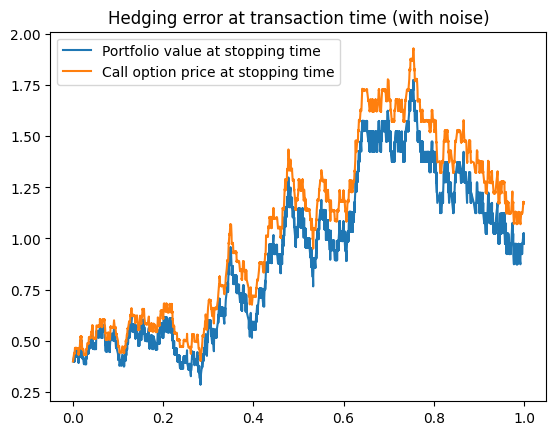

In [139]:
# calculate the hedging error
print(f"End of day hedging error: {call_option_price_2[-1]-portfolio_value_2[-1]}")
# plot the hedging error
plt.plot(t[tau], portfolio_value_2, label = 'Portfolio value at stopping time')
plt.plot(t[tau], call_option_price_2, label = 'Call option price at stopping time')
plt.legend()
plt.title("Hedging error at transaction time (with noise)")
plt.show()

In [140]:
# plotly fancy code
# calculate the hedging error
print(f"End of day hedging error: {call_option_price_2[-1]-portfolio_value_2[-1]}")

# create a plotly graph
fig = go.Figure()

# add traces
fig.add_trace(go.Scatter(x=t[tau], y=portfolio_value_2, mode='lines', name='Portfolio value at stopping time'))
fig.add_trace(go.Scatter(x=t[tau], y=call_option_price_2, mode='lines', name='Call option price at stopping time'))

# set the title
fig.update_layout(title='Hedging error at transaction time (with noise)')

# show the plot
fig.show()

End of day hedging error: 0.15402815200881181


### Optimal Strategy: Hedge only for significant price change, with microstructural noise

In this case, for simplicity we assume $m=1$, which means that price always change by 1 tick, we only rebalance portfolio once the price has change by $l_\alpha$ tick. This is equivalent to the transaction price now lying on a subgrid with new tick size $\alpha l_\alpha$. In this case, the transaction times are given by:
$$
\tau_{i+1}^{(l)} = \inf \{ t > \tau_i^{(l)}, X_t = {X^{(\alpha)}_{\tau_i}} - \alpha\left( l_\alpha - \frac{1}{2} + \eta \right) \text{ or } X_t = {X^{(\alpha)}_{\tau_i}}+ \alpha\left( l_\alpha - \frac{1}{2} + \eta \right) \}.
$$
Let $\phi^{(l)}(t) = \sup\{\tau_i^{(l)} : \tau_i^{(l)} < t\}$. The hedging error is given as:
$$
L^{(3)}_{\alpha,t} = \int_{0}^{T}  \dot{C}_x (u, X_u) dX_u   - \int_{0}^{T}\dot{C}_x (\phi^{(l)}(u), X_{\phi^{(l)}(u)}) dP_u \\
$$

with discrete version given as:

$$
L^{(3)}_{\alpha,t} = C_x (T, X_T)  - \left( \sum_{i=1}^{m} \Delta C_x (\tau_{i-1}^{(l)}, X_{\tau_{i-1}^{(l)}}) \cdot (P_{\tau_i^{(l)}} - P_{\tau_{i-1}^{(l)}}) \right) \\
$$


In [141]:
l_alpha = round(alpha**(-1/2)) # round to nearest integer

def uncertainty_zone_price_adjusted(x, alpha, eta,l_alpha):
    """
    input:
    x: the underlying price
    alpha: the ticksize
    eta: the proportion of continuation
    L: the size of jump
    l_alpha: rehedge for every l_alpha ticks
    output:
    p: the price of uncertainty zone
    eta_hat: the estimated proportion of continuation
    tau: list of times where transaction happens, this depends on the rehedge frequency l_alpha
    """
    p = np.zeros(len(x)) # price of uncertainty zone
    p_discrete = [] # discrete price under uncertainty zone model
    N_a = 0 # number of alternation
    N_c = 0 # number of continuation
    tau = [] # collect the time where transaction happens
    # construct the uncertainty zone price
    p[0] = x[0]
    p_discrete.append(p[0])
    for i in range(1, len(p)):
        if x[i] - p[i-1] >= alpha*(l_alpha-.5+eta): # if efficient price is higher than the upper bound
            p[i] = p[i-1] + L*alpha
            p_discrete.append(p[i])
            tau.append(i)
        elif x[i] - p[i-1] <= - alpha*(l_alpha-.5+eta): # if efficient price is lower than the lower bound
            p[i] = p[i-1] - L*alpha
            p_discrete.append(p[i])
            tau.append(i)
        else:
            p[i] = p[i-1] # last traded price remain the same
    # calculate the number of alternation and continuation
    p_discrete = np.array(p_discrete)
    for i in range(2, len(p_discrete)):
        if np.sign(p_discrete[i] - p_discrete[i-1]) != np.sign(p_discrete[i-1] - p_discrete[i-2]):
            N_a += 1
        else:
            N_c += 1
    eta_hat = N_c/(2*N_a)
    return p, eta_hat, tau

p, eta_hat, tau = uncertainty_zone_price(x, alpha, eta, l_alpha)
# Initialize the portfolio value array and the hedging position array
portfolio_value_3 = np.zeros(len(tau)) # benchmark hedging portfolio value
hedging_position_3 = np.zeros(len(tau)) # hedging position dC/dS
call_option_price_3 = np.zeros(len(tau)) # call option price

# given the stopping time tau, we can calculate the hedging position and portfolio value
call_option_price_3[0] = BSCall(x[0], K, sigma, T - t[0])
portfolio_value_3[0] = call_option_price_3[0]
hedging_position_3[0] = delta(x[0], K, sigma, T - t[0]) # calculate delta still using efficient price x

for i in tqdm(range(1, len(tau)),colour='green'):
    dT = T - t[tau[i]] # Remaining time to maturity
    # Update the portfolio value for changes in the option price and underlying asset
    portfolio_value_3[i] = portfolio_value_3[i-1] + hedging_position_3[i-1] * (p[tau[i]] - p[tau[i-1]])
    # Re-hedge the portfolio by adjusting the position in the underlying
    hedging_position_3[i] = delta(x[tau[i]], K, sigma, dT)
    # compute the call option price
    call_option_price_3[i] = BSCall(x[tau[i]], K, sigma, dT)


100%|██████████| 33/33 [00:00<00:00, 12951.44it/s]


End of day hedging error: 0.17847609484253324


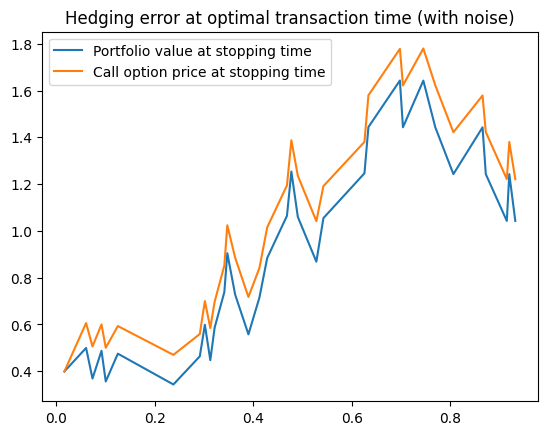

In [142]:
# calculate the hedging error
print(f"End of day hedging error: {call_option_price_3[-1]-portfolio_value_3[-1]}")
# plot the hedging error
plt.plot(t[tau], portfolio_value_3, label = 'Portfolio value at stopping time')
plt.plot(t[tau], call_option_price_3, label = 'Call option price at stopping time')
plt.legend()
plt.title("Hedging error at optimal transaction time (with noise)")
plt.show()

In [143]:
# plotly fancy code
# calculate the hedging error
print(f"End of day hedging error: {call_option_price_3[-1]-portfolio_value_3[-1]}")

# create a plotly graph
fig = go.Figure()

# add traces
fig.add_trace(go.Scatter(x=t[tau], y=portfolio_value_3, mode='lines', name='Portfolio value at stopping time'))
fig.add_trace(go.Scatter(x=t[tau], y=call_option_price_3, mode='lines', name='Call option price at stopping time'))

# set the title
fig.update_layout(title='Hedging error at optimal transaction time (with noise)')

# show the plot
fig.show()

End of day hedging error: 0.17847609484253324


## Monte Carlo
- simulate n sample paths of stock price under the BS dynamics $dS_t=S_t\sigma(t,S_t)dW_t$
- compute the hedging portfolio under the uncertainty zone model:
    1. without noise, hedge for every price change
    2. with noise, hedge for every last traded
    3. with noise, hedge for every optimal number of ticks
- compare hedging error distribution
    

In [110]:
def simulate_BS_n(sigma, x0, T, n, number_of_paths):
    """
    Simulate number_of_simulations of black scholes path
    using the exact solution
    n: number of time steps
    number_of_paths: number of paths to simulate
    """
    dt = T/n
    t = np.linspace(0, T, n) # time grid
    x = np.zeros((number_of_paths, n))
    x[:, 0] = x0
    for i in tqdm(range(1, n), colour='green', desc="simulate paths"):
        dW = np.random.normal(size=number_of_paths) * np.sqrt(dt)  # Brownian increments
        x[:, i] = x[:, i-1] * np.exp((0.5 * sigma**2) * dt + sigma * dW)
    return t, x

def uncertainty_zone_price_adjusted_n(x, alpha, eta, l_alpha):
    """
    this is for multiple paths
    input:
    x: the underlying price (2D array where each row is a path)
    alpha: the ticksize
    eta: the proportion of continuation
    l_alpha: rehedge for every l_alpha ticks
    output:
    p: the price of uncertainty zone for each path, dimnesion is the same as x
    eta_hat: the estimated proportion of continuation for each path
    tau: list of times where transaction happens for each path, this depends on the rehedge frequency l_alpha
    """
    number_of_paths = x.shape[0]
    p = np.zeros_like(x) # price of uncertainty zone
    eta_hat = np.zeros(number_of_paths)
    tau = [None] * number_of_paths

    for path in tqdm(range(number_of_paths),colour = 'green', desc = "calculate uncertainty zone price"):
        p_discrete = [] # discrete price under uncertainty zone model
        N_a = 0 # number of alternation
        N_c = 0 # number of continuation
        tau[path] = [] # collect the time where transaction happens
        # construct the uncertainty zone price
        p[path, 0] = x[path, 0]
        p_discrete.append(p[path, 0])
        for i in range(1, len(p[path])):
            if x[path, i] - p[path, i-1] >= alpha*(l_alpha-.5+eta): # if efficient price is higher than the upper bound
                p[path, i] = p[path, i-1] + L*alpha
                p_discrete.append(p[path, i])
                tau[path].append(i)
            elif x[path, i] - p[path, i-1] <= - alpha*(l_alpha-.5+eta): # if efficient price is lower than the lower bound
                p[path, i] = p[path, i-1] - L*alpha
                p_discrete.append(p[path, i])
                tau[path].append(i)
            else:
                p[path, i] = p[path, i-1] # last traded price remain the same
        # calculate the number of alternation and continuation
        p_discrete = np.array(p_discrete)
        for i in range(2, len(p_discrete)):
            if np.sign(p_discrete[i] - p_discrete[i-1]) != np.sign(p_discrete[i-1] - p_discrete[i-2]):
                N_a += 1
            else:
                N_c += 1
        eta_hat[path] = N_c/(2*N_a) if N_a != 0 else 0

    return p, eta_hat, tau

In [147]:
number_of_paths = 1000
t, x = simulate_BS_n(sigma, x0, T, n, number_of_paths)

simulate paths:   0%|          | 0/287999 [00:00<?, ?it/s]

simulate paths: 100%|██████████| 287999/287999 [00:08<00:00, 34948.06it/s]


In [148]:
# generate the price under uncertainty zone model, here we assume L = 1
eta = 0.05
L = 1
p, eta_hat, tau = uncertainty_zone_price_adjusted_n(x, alpha, eta, L) # rehedge at every price change

calculate uncertainty zone price:  26%|██▋       | 263/1000 [00:37<01:44,  7.02it/s]


KeyboardInterrupt: 

In [113]:
error_1 = np.zeros(number_of_paths) # store the error for each path

# calculate the portfolio value and hedging position for each path then store in the array
for i in tqdm(range(len(tau)),colour = 'green', desc = "calculate portfolio value and hedging position"):
    portfolio_value = np.zeros(len(tau[i])) # benchmark hedging portfolio value
    hedging_position = np.zeros(len(tau[i])) # hedging position dC/dS
    portfolio_value[0] = BSCall(x[i, 0], K, sigma, T - t[0]) # initial portfolio value
    stop_time = tau[i] # stopping times for the ith path
    for j in range(1, len(tau[i])):
        current = stop_time[j] # the time where the jth transaction happens
        last = stop_time[j-1] # the time where the (j-1)th transaction happens
        dT = T - t[current]
        # Update the portfolio value for changes in the option price and underlying asset
        portfolio_value[j] = portfolio_value[j-1] + hedging_position[j-1] * (x[i, current] - x[i, last])
        # Re-hedge the portfolio by adjusting the position in the underlying

        hedging_position[j] = delta(x[i, current], K, sigma, dT)
    # calculate the call option price
    call_option_price_final = x[i, -1] - K if x[i, -1] > K else 0 # maturity call option price
    #call_option_price_final = BSCall(x[i, -1], K, sigma, 0) # maturity call option price, need to revisit later
    # calculate the error
    error_1[i] = call_option_price_final - portfolio_value[-1]

calculate portfolio value and hedging position:   0%|          | 2/1000 [00:00<01:25, 11.69it/s]/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/1427530537.py:30: RuntimeWarning:

divide by zero encountered in scalar divide

calculate portfolio value and hedging position: 100%|██████████| 1000/1000 [01:25<00:00, 11.71it/s]


In [114]:
# 2nd strategy: hedge at every price change with noise
error_2 = np.zeros(number_of_paths) # store the error for each path

# calculate the portfolio value and hedging position for each path then store in the array
for i in tqdm(range(len(tau)),colour = 'green', desc = "calculate portfolio value and hedging position"):
    portfolio_value = np.zeros(len(tau[i])) # benchmark hedging portfolio value
    hedging_position = np.zeros(len(tau[i])) # hedging position dC/dS
    portfolio_value[0] = BSCall(x[i, 0], K, sigma, T - t[0]) # initial portfolio value
    stop_time = tau[i] # stopping times for the ith path
    for j in range(1, len(tau[i])):
        current = stop_time[j] # the time where the jth transaction happens
        last = stop_time[j-1] # the time where the (j-1)th transaction happens
        dT = T - t[current]
        # Update the portfolio value for changes in the option price and underlying asset
        portfolio_value[j] = portfolio_value[j-1] + hedging_position[j-1] * (p[i, current] - p[i, last])
        
        # Re-hedge the portfolio by adjusting the position in the underlying
        hedging_position[j] = delta(x[i, current], K, sigma, dT)
    # calculate the call option price
    call_option_price_final = BSCall(x[i, -1], K, sigma, 0) # maturity call option price, need to revisit later
    # calculate the error
    error_2[i] = call_option_price_final - portfolio_value[-1]


calculate portfolio value and hedging position:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/1427530537.py:19: RuntimeWarning:

divide by zero encountered in scalar divide

calculate portfolio value and hedging position:   0%|          | 2/1000 [00:00<01:24, 11.83it/s]/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/1427530537.py:30: RuntimeWarning:

divide by zero encountered in scalar divide

calculate portfolio value and hedging position: 100%|██████████| 1000/1000 [01:23<00:00, 11.92it/s]


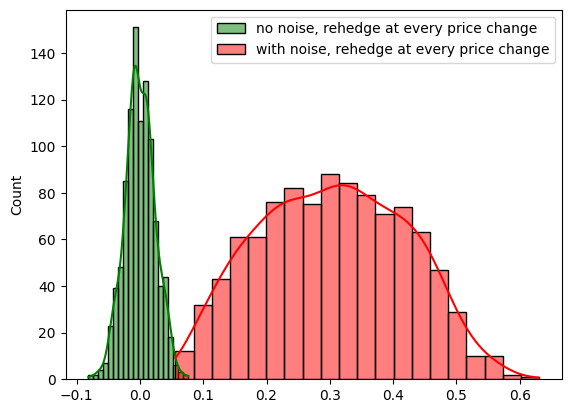

In [115]:
sns.histplot(error_1, label = "no noise, rehedge at every price change", bins = 20, color = 'green', kde = True)
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 20, color = 'red', kde = True)
plt.legend()

In [116]:
# 3rd strategy: hedge at every l_alpha price change
l_alpha = 5 # the same as book
p_3, eta_hat, tau_3 = uncertainty_zone_price_adjusted_n(x, alpha, eta, l_alpha) # rehedge at every l_alpha price change

calculate uncertainty zone price: 100%|██████████| 1000/1000 [02:19<00:00,  7.17it/s]


In [117]:
error_3 = np.zeros(number_of_paths) # store the error for each path

# calculate the portfolio value and hedging position for each path then store in the array
for i in tqdm(range(len(tau_3)),colour = 'green', desc = "calculate portfolio value and hedging position"):
    portfolio_value = np.zeros(len(tau_3[i])) # benchmark hedging portfolio value
    hedging_position = np.zeros(len(tau_3[i])) # hedging position dC/dS
    portfolio_value[0] = BSCall(x[i, 0], K, sigma, T - t[0]) # initial portfolio value
    stop_time = tau_3[i] # stopping times for the ith path
    for j in range(1, len(tau_3[i])):
        current = stop_time[j] # the time where the jth transaction happens
        last = stop_time[j-1] # the time where the (j-1)th transaction happens
        dT = T - t[current]
        # Update the portfolio value for changes in the option price and underlying asset
        portfolio_value[j] = portfolio_value[j-1] + hedging_position[j-1] * (p_3[i, current] - p_3[i, last])
    
        # Re-hedge the portfolio by adjusting the position in the underlying
        hedging_position[j] = delta(x[i, current], K, sigma, dT)
    # calculate the call option price
    call_option_price_final = BSCall(x[i, -1], K, sigma, 0) # maturity call option price, need to revisit later
    # calculate the error
    error_3[i] = call_option_price_final - portfolio_value[-1]


calculate portfolio value and hedging position:   0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/nm/7d2mnp_x4y1c6q58d9_5h1140000gn/T/ipykernel_89541/1427530537.py:19: RuntimeWarning:

divide by zero encountered in scalar divide

calculate portfolio value and hedging position: 100%|██████████| 1000/1000 [00:01<00:00, 519.34it/s]


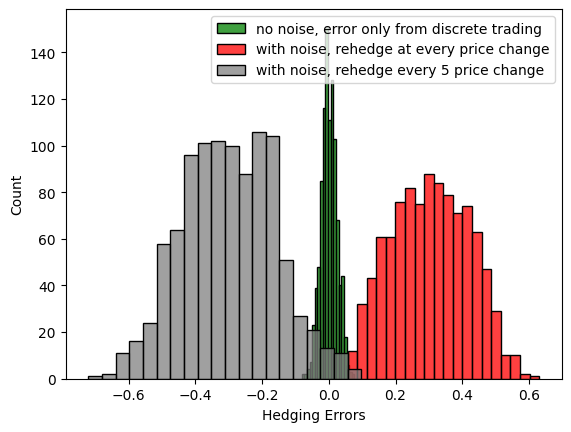

In [118]:
sns.histplot(error_1, label = "no noise, error only from discrete trading", bins = 20, color = 'green')
sns.histplot(error_2, label = "with noise, rehedge at every price change", bins = 20, color = 'red')
sns.histplot(error_3, label = f"with noise, rehedge every {l_alpha} price change", bins = 20, color='grey')
plt.xlabel("Hedging Errors")
plt.legend()

In [121]:
print("strategy 1 has std and mean of error:", np.std(error_1), np.mean(error_1))
print("strategy 2 has std and mean of error:", np.std(error_2), np.mean(error_2))
print("strategy 3 has std and mean of error:", np.std(error_3),np.mean(error_3))

strategy 1 has std and mean of error: 0.023810022696244274 0.00011429585264775049
strategy 2 has std and mean of error: 0.11519738827143139 0.3044029559309975
strategy 3 has std and mean of error: 0.13982242798268363 -0.30067381480192273
